In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [4]:
def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

In [6]:
train = pd.read_csv('../data/public_raw.train.csv')
train['is_train']= 1
test = pd.read_csv('../data/public_raw.test.csv')
test['is_train']=0

train_len = train.shape[0]

df = pd.concat([train, test])

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [8]:
df.sort_values(by='ID',ascending=True, inplace=True)

In [9]:
df.head()

ID  is_train  light_strength      P_A     P_B      P_C         y   P_avg  \
0   1         0               1     0.00    0.00     0.00       NaN    0.00   
1   9         0              13   909.72  148.05  1031.03       NaN  696.27   
0  10         1              34   976.86  155.98  1087.50  1.437752  740.11   
1  11         1              30  1128.40  172.08  1132.56  1.692575  811.01   
2  12         1              41  1279.25  166.06  1310.40  1.975787  918.57   

   board_t  env_t     ...      V_C   I_A   I_B   I_C  efficiency  \
0     0.01    0.1     ...        0  0.00  0.00  0.00        0.00   
1   -19.33  -17.5     ...      721  1.26  0.21  1.43      198.32   
0   -19.14  -17.4     ...      725  1.34  0.22  1.50       80.55   
1   -18.73  -17.3     ...      726  1.55  0.24  1.56       99.90   
2   -17.54  -17.0     ...      720  1.75  0.23  1.82       82.48   

   efficiency_A  efficiency_B  efficiency_C  wind_direction  wind_speed  
0          0.00          0.00          0.00               1         0.1  
1        259.11         42.17        293.66             273         0.3  
0        106.32         16.98        118.36             272         0.6  
1        139.00         21.20        139.51             275         0.8  
2        114.86         14.91        117.66             283         1.1  

[5 rows x 22 columns]

In [25]:
def get_ts_feature(df, f_name, prefix='', v_len = 25):
    v = df[f_name].values.tolist()
    # prev
    temp_list = []
    for i in range(df.shape[0]):
#         print("base part:"+str(v[0:20]))
#         print("first part:"+str(v[i-v_len:i]))
#         print("second part:"+str(v[i-v_len:i][::-1]))
        temp_list.append(v[i-v_len:i][::-1])
    temp_df = pd.DataFrame(temp_list)
    temp_df.columns = [prefix+'prev_%d'%x for x in range(v_len)]
    temp_df['ID'] = df['ID'].values
    
    # succ
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i+1:i+v_len+1])
    temp_df2 = pd.DataFrame(temp_list)
    temp_df2.columns = [prefix+'succ_%d'%x for x in range(v_len)]
    temp_df2['ID'] = df['ID'].values
    
    temp_df = temp_df.merge(temp_df2, on='ID', how='left')
    return temp_df

In [26]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
    df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)

In [30]:
x = get_ts_feature(df, 'light_strength', 'ls')
x

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]
second part:[]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[]

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[273, 271, 254, 249, 245, 249, 247, 236, 309, 271, 309, 346, 328, 344, 331, 214, 210, 201, 216, 215, 252, 252, 176, 165, 193]
second part:[193, 165, 176, 252, 252, 215, 216, 201, 210, 214, 331, 344, 328, 346, 309, 271, 309, 236, 247, 249, 245, 249, 254, 271, 273]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[271, 254, 249, 245, 249, 247, 236, 309, 271, 309, 346, 328, 344, 331, 214, 210, 201, 216, 215, 252, 252, 176, 165, 193, 184]
second part:[184, 193, 165, 176, 252, 252, 215, 216, 201, 210, 214, 331, 344, 328, 346, 309, 271, 309, 236, 247, 249, 245, 249, 254, 271]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[254, 249, 245, 249, 247, 236, 309, 271, 309, 346, 328, 344, 331, 214, 210, 201, 216, 215, 252, 252, 176, 165, 193, 184, 166]
second part:[166, 1

first part:[382, 380, 382, 385, 385, 386, 386, 383, 382, 383, 383, 383, 382, 382, 384, 383, 380, 378, 376, 375, 373, 370, 368, 363, 360]
second part:[360, 363, 368, 370, 373, 375, 376, 378, 380, 383, 384, 382, 382, 383, 383, 383, 382, 383, 386, 386, 385, 385, 382, 380, 382]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[380, 382, 385, 385, 386, 386, 383, 382, 383, 383, 383, 382, 382, 384, 383, 380, 378, 376, 375, 373, 370, 368, 363, 360, 360]
second part:[360, 360, 363, 368, 370, 373, 375, 376, 378, 380, 383, 384, 382, 382, 383, 383, 383, 382, 383, 386, 386, 385, 385, 382, 380]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[382, 385, 385, 386, 386, 383, 382, 383, 383, 383, 382, 382, 384, 383, 380, 378, 376, 375, 373, 370, 368, 363, 360, 360, 358]
second part:[358, 360, 360, 363, 368, 370, 373, 375, 376, 378, 380, 383, 384, 382, 382, 383, 383, 383, 382, 383, 386,

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[290, 293, 297, 301, 308, 305, 305, 305, 312, 319, 321, 325, 325, 327, 329, 329, 331, 339, 338, 340, 341, 341, 344, 345, 347]
second part:[347, 345, 344, 341, 341, 340, 338, 339, 331, 329, 329, 327, 325, 325, 321, 319, 312, 305, 305, 305, 308, 301, 297, 293, 290]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[293, 297, 301, 308, 305, 305, 305, 312, 319, 321, 325, 325, 327, 329, 329, 331, 339, 338, 340, 341, 341, 344, 345, 347, 350]
second part:[350, 347, 345, 344, 341, 341, 340, 338, 339, 331, 329, 329, 327, 325, 325, 321, 319, 312, 305, 305, 305, 308, 301, 297, 293]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[297, 301, 308, 305, 305, 305, 312, 319, 321, 325, 325, 327, 329, 329, 331, 339, 338, 340, 341, 341, 344, 345, 347, 350, 351]
second part:[351, 3

first part:[155, 158, 164, 177, 179, 183, 186, 193, 199, 205, 216, 222, 225, 227, 238, 245, 249, 257, 260, 260, 260, 275, 277, 280, 281]
second part:[281, 280, 277, 275, 260, 260, 260, 257, 249, 245, 238, 227, 225, 222, 216, 205, 199, 193, 186, 183, 179, 177, 164, 158, 155]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[158, 164, 177, 179, 183, 186, 193, 199, 205, 216, 222, 225, 227, 238, 245, 249, 257, 260, 260, 260, 275, 277, 280, 281, 288]
second part:[288, 281, 280, 277, 275, 260, 260, 260, 257, 249, 245, 238, 227, 225, 222, 216, 205, 199, 193, 186, 183, 179, 177, 164, 158]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[164, 177, 179, 183, 186, 193, 199, 205, 216, 222, 225, 227, 238, 245, 249, 257, 260, 260, 260, 275, 277, 280, 281, 288, 293]
second part:[293, 288, 281, 280, 277, 275, 260, 260, 260, 257, 249, 245, 238, 227, 225, 222, 216, 205, 199, 193, 186,

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[1, 1, 2, 3, 3, 11, 7, 13, 11, 15, 22, 21, 28, 24, 25, 33, 34, 36, 39, 41, 43, 49, 52, 53, 55]
second part:[55, 53, 52, 49, 43, 41, 39, 36, 34, 33, 25, 24, 28, 21, 22, 15, 11, 13, 7, 11, 3, 3, 2, 1, 1]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[1, 2, 3, 3, 11, 7, 13, 11, 15, 22, 21, 28, 24, 25, 33, 34, 36, 39, 41, 43, 49, 52, 53, 55, 60]
second part:[60, 55, 53, 52, 49, 43, 41, 39, 36, 34, 33, 25, 24, 28, 21, 22, 15, 11, 13, 7, 11, 3, 3, 2, 1]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[2, 3, 3, 11, 7, 13, 11, 15, 22, 21, 28, 24, 25, 33, 34, 36, 39, 41, 43, 49, 52, 53, 55, 60, 60]
second part:[60, 60, 55, 53, 52, 49, 43, 41, 39, 36, 34, 33, 25, 24, 28, 21, 22, 15, 11, 13, 7, 11, 3, 3, 2]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100

first part:[40, 31, 24, 18, 11, 8, 7, 6, 1, 1, 6, 3, 5, 11, 7, 7, 8, 13, 12, 12, 17, 18, 20, 22, 22]
second part:[22, 22, 20, 18, 17, 12, 12, 13, 8, 7, 7, 11, 5, 3, 6, 1, 1, 6, 7, 8, 11, 18, 24, 31, 40]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[31, 24, 18, 11, 8, 7, 6, 1, 1, 6, 3, 5, 11, 7, 7, 8, 13, 12, 12, 17, 18, 20, 22, 22, 22]
second part:[22, 22, 22, 20, 18, 17, 12, 12, 13, 8, 7, 7, 11, 5, 3, 6, 1, 1, 6, 7, 8, 11, 18, 24, 31]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[24, 18, 11, 8, 7, 6, 1, 1, 6, 3, 5, 11, 7, 7, 8, 13, 12, 12, 17, 18, 20, 22, 22, 22, 30]
second part:[30, 22, 22, 22, 20, 18, 17, 12, 12, 13, 8, 7, 7, 11, 5, 3, 6, 1, 1, 6, 7, 8, 11, 18, 24]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[18, 11, 8, 7, 6, 1, 1, 6, 3, 5, 11, 7, 7, 8, 13, 12, 12, 17, 18, 20, 22, 22, 22, 30, 

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[139, 132, 121, 118, 107, 94, 89, 85, 83, 57, 24, 23, 20, 19, 17, 16, 12, 13, 10, 8, 6, 5, 5, 1, 1]
second part:[1, 1, 5, 5, 6, 8, 10, 13, 12, 16, 17, 19, 20, 23, 24, 57, 83, 85, 89, 94, 107, 118, 121, 132, 139]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[132, 121, 118, 107, 94, 89, 85, 83, 57, 24, 23, 20, 19, 17, 16, 12, 13, 10, 8, 6, 5, 5, 1, 1, 1]
second part:[1, 1, 1, 5, 5, 6, 8, 10, 13, 12, 16, 17, 19, 20, 23, 24, 57, 83, 85, 89, 94, 107, 118, 121, 132]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[121, 118, 107, 94, 89, 85, 83, 57, 24, 23, 20, 19, 17, 16, 12, 13, 10, 8, 6, 5, 5, 1, 1, 1, 223]
second part:[223, 1, 1, 1, 5, 5, 6, 8, 10, 13, 12, 16, 17, 19, 20, 23, 24, 57, 83, 85, 89, 94, 107, 118, 121]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76,

first part:[85, 89, 108, 106, 110, 118, 123, 130, 143, 153, 161, 164, 169, 183, 195, 199, 212, 216, 224, 228, 242, 245, 255, 265, 273]
second part:[273, 265, 255, 245, 242, 228, 224, 216, 212, 199, 195, 183, 169, 164, 161, 153, 143, 130, 123, 118, 110, 106, 108, 89, 85]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[89, 108, 106, 110, 118, 123, 130, 143, 153, 161, 164, 169, 183, 195, 199, 212, 216, 224, 228, 242, 245, 255, 265, 273, 279]
second part:[279, 273, 265, 255, 245, 242, 228, 224, 216, 212, 199, 195, 183, 169, 164, 161, 153, 143, 130, 123, 118, 110, 106, 108, 89]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[108, 106, 110, 118, 123, 130, 143, 153, 161, 164, 169, 183, 195, 199, 212, 216, 224, 228, 242, 245, 255, 265, 273, 279, 292]
second part:[292, 279, 273, 265, 255, 245, 242, 228, 224, 216, 212, 199, 195, 183, 169, 164, 161, 153, 143, 130, 123, 118, 

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[471, 486, 485, 487, 488, 497, 503, 509, 508, 517, 511, 514, 521, 517, 526, 529, 521, 527, 529, 536, 546, 536, 536, 530, 532]
second part:[532, 530, 536, 536, 546, 536, 529, 527, 521, 529, 526, 517, 521, 514, 511, 517, 508, 509, 503, 497, 488, 487, 485, 486, 471]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[486, 485, 487, 488, 497, 503, 509, 508, 517, 511, 514, 521, 517, 526, 529, 521, 527, 529, 536, 546, 536, 536, 530, 532, 540]
second part:[540, 532, 530, 536, 536, 546, 536, 529, 527, 521, 529, 526, 517, 521, 514, 511, 517, 508, 509, 503, 497, 488, 487, 485, 486]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[485, 487, 488, 497, 503, 509, 508, 517, 511, 514, 521, 517, 526, 529, 521, 527, 529, 536, 546, 536, 536, 530, 532, 540, 552]
second part:[552, 5

second part:[402, 394, 380, 378, 372, 362, 351, 345, 336, 324, 322, 317, 316, 296, 288, 283, 270, 266, 253, 238, 231, 223, 219, 200, 195]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[200, 219, 223, 231, 238, 253, 266, 270, 283, 288, 296, 316, 317, 322, 324, 336, 345, 351, 362, 372, 378, 380, 394, 402, 403]
second part:[403, 402, 394, 380, 378, 372, 362, 351, 345, 336, 324, 322, 317, 316, 296, 288, 283, 270, 266, 253, 238, 231, 223, 219, 200]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[219, 223, 231, 238, 253, 266, 270, 283, 288, 296, 316, 317, 322, 324, 336, 345, 351, 362, 372, 378, 380, 394, 402, 403, 413]
second part:[413, 403, 402, 394, 380, 378, 372, 362, 351, 345, 336, 324, 322, 317, 316, 296, 288, 283, 270, 266, 253, 238, 231, 223, 219]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[223, 2

first part:[351, 311, 300, 293, 292, 292, 275, 269, 263, 263, 294, 298, 298, 304, 312, 310, 314, 301, 295, 298, 298, 273, 274, 277, 249]
second part:[249, 277, 274, 273, 298, 298, 295, 301, 314, 310, 312, 304, 298, 298, 294, 263, 263, 269, 275, 292, 292, 293, 300, 311, 351]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[311, 300, 293, 292, 292, 275, 269, 263, 263, 294, 298, 298, 304, 312, 310, 314, 301, 295, 298, 298, 273, 274, 277, 249, 237]
second part:[237, 249, 277, 274, 273, 298, 298, 295, 301, 314, 310, 312, 304, 298, 298, 294, 263, 263, 269, 275, 292, 292, 293, 300, 311]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[300, 293, 292, 292, 275, 269, 263, 263, 294, 298, 298, 304, 312, 310, 314, 301, 295, 298, 298, 273, 274, 277, 249, 237, 208]
second part:[208, 237, 249, 277, 274, 273, 298, 298, 295, 301, 314, 310, 312, 304, 298, 298, 294, 263, 263, 269, 275,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




second part:[634, 646, 650, 649, 650, 661, 669, 663, 666, 673, 687, 686, 686, 702, 704, 702, 687, 696, 693, 695, 700, 689, 660, 677, 689]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[677, 660, 689, 700, 695, 693, 696, 687, 702, 704, 702, 686, 686, 687, 673, 666, 663, 669, 661, 650, 649, 650, 646, 634, 659]
second part:[659, 634, 646, 650, 649, 650, 661, 669, 663, 666, 673, 687, 686, 686, 702, 704, 702, 687, 696, 693, 695, 700, 689, 660, 677]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[660, 689, 700, 695, 693, 696, 687, 702, 704, 702, 686, 686, 687, 673, 666, 663, 669, 661, 650, 649, 650, 646, 634, 659, 643]
second part:[643, 659, 634, 646, 650, 649, 650, 661, 669, 663, 666, 673, 687, 686, 686, 702, 704, 702, 687, 696, 693, 695, 700, 689, 660]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[689, 

second part:[415, 417, 410, 428, 423, 348, 478, 523, 436, 427, 463, 355, 530, 557, 471, 554, 527, 514, 521, 549, 588, 588, 549, 327, 327]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[327, 549, 588, 588, 549, 521, 514, 527, 554, 471, 557, 530, 355, 463, 427, 436, 523, 478, 348, 423, 428, 410, 417, 415, 435]
second part:[435, 415, 417, 410, 428, 423, 348, 478, 523, 436, 427, 463, 355, 530, 557, 471, 554, 527, 514, 521, 549, 588, 588, 549, 327]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[549, 588, 588, 549, 521, 514, 527, 554, 471, 557, 530, 355, 463, 427, 436, 523, 478, 348, 423, 428, 410, 417, 415, 435, 375]
second part:[375, 435, 415, 417, 410, 428, 423, 348, 478, 523, 436, 427, 463, 355, 530, 557, 471, 554, 527, 514, 521, 549, 588, 588, 549]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[588, 5

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[190, 187, 168, 156, 154, 154, 140, 128, 112, 110, 108, 104, 94, 89, 87, 79, 78, 80, 80, 78, 74, 72, 64, 63, 60]
second part:[60, 63, 64, 72, 74, 78, 80, 80, 78, 79, 87, 89, 94, 104, 108, 110, 112, 128, 140, 154, 154, 156, 168, 187, 190]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[187, 168, 156, 154, 154, 140, 128, 112, 110, 108, 104, 94, 89, 87, 79, 78, 80, 80, 78, 74, 72, 64, 63, 60, 60]
second part:[60, 60, 63, 64, 72, 74, 78, 80, 80, 78, 79, 87, 89, 94, 104, 108, 110, 112, 128, 140, 154, 154, 156, 168, 187]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[168, 156, 154, 154, 140, 128, 112, 110, 108, 104, 94, 89, 87, 79, 78, 80, 80, 78, 74, 72, 64, 63, 60, 60, 60]
second part:[60, 60, 60, 63, 64, 72, 74, 78, 80, 80, 78, 79, 87, 89, 94, 104, 108, 110, 

second part:[181, 269, 165, 167, 134, 1, 21, 25, 30, 29, 30, 40, 40, 30, 23, 31, 38, 43, 44, 52, 60, 49, 41, 36, 32]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[36, 41, 49, 60, 52, 44, 43, 38, 31, 23, 30, 40, 40, 30, 29, 30, 25, 21, 1, 134, 167, 165, 269, 181, 209]
second part:[209, 181, 269, 165, 167, 134, 1, 21, 25, 30, 29, 30, 40, 40, 30, 23, 31, 38, 43, 44, 52, 60, 49, 41, 36]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[41, 49, 60, 52, 44, 43, 38, 31, 23, 30, 40, 40, 30, 29, 30, 25, 21, 1, 134, 167, 165, 269, 181, 209, 182]
second part:[182, 209, 181, 269, 165, 167, 134, 1, 21, 25, 30, 29, 30, 40, 40, 30, 23, 31, 38, 43, 44, 52, 60, 49, 41]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[49, 60, 52, 44, 43, 38, 31, 23, 30, 40, 40, 30, 29, 30, 25, 21, 1, 134, 167, 165, 269, 181, 209, 182, 248

base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[144, 146, 155, 162, 168, 178, 181, 186, 190, 199, 209, 212, 224, 230, 234, 236, 244, 246, 249, 252, 260, 276, 278, 281, 281]
second part:[281, 281, 278, 276, 260, 252, 249, 246, 244, 236, 234, 230, 224, 212, 209, 199, 190, 186, 181, 178, 168, 162, 155, 146, 144]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[146, 155, 162, 168, 178, 181, 186, 190, 199, 209, 212, 224, 230, 234, 236, 244, 246, 249, 252, 260, 276, 278, 281, 281, 281]
second part:[281, 281, 281, 278, 276, 260, 252, 249, 246, 244, 236, 234, 230, 224, 212, 209, 199, 190, 186, 181, 178, 168, 162, 155, 146]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[155, 162, 168, 178, 181, 186, 190, 199, 209, 212, 224, 230, 234, 236, 244, 246, 249, 252, 260, 276, 278, 281, 281, 281, 287]
second part:[287, 2

second part:[760, 760, 765, 774, 769, 745, 765, 760, 760, 756, 754, 756, 733, 733, 705, 699, 701, 746, 702, 688, 726, 701, 699, 651, 644]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[651, 699, 701, 726, 688, 702, 746, 701, 699, 705, 733, 733, 756, 754, 756, 760, 760, 765, 745, 769, 774, 765, 760, 760, 775]
second part:[775, 760, 760, 765, 774, 769, 745, 765, 760, 760, 756, 754, 756, 733, 733, 705, 699, 701, 746, 702, 688, 726, 701, 699, 651]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[699, 701, 726, 688, 702, 746, 701, 699, 705, 733, 733, 756, 754, 756, 760, 760, 765, 745, 769, 774, 765, 760, 760, 775, 774]
second part:[774, 775, 760, 760, 765, 774, 769, 745, 765, 760, 760, 756, 754, 756, 733, 733, 705, 699, 701, 746, 702, 688, 726, 701, 699]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[701, 7

second part:[190, 169, 130, 104, 104, 117, 118, 123, 134, 229, 302, 304, 142, 97, 94, 257, 257, 474, 311, 166, 181, 254, 416, 407, 361]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[407, 416, 254, 181, 166, 311, 474, 257, 257, 94, 97, 142, 304, 302, 229, 134, 123, 118, 117, 104, 104, 130, 169, 190, 241]
second part:[241, 190, 169, 130, 104, 104, 117, 118, 123, 134, 229, 302, 304, 142, 97, 94, 257, 257, 474, 311, 166, 181, 254, 416, 407]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[416, 254, 181, 166, 311, 474, 257, 257, 94, 97, 142, 304, 302, 229, 134, 123, 118, 117, 104, 104, 130, 169, 190, 241, 249]
second part:[249, 241, 190, 169, 130, 104, 104, 117, 118, 123, 134, 229, 302, 304, 142, 97, 94, 257, 257, 474, 311, 166, 181, 254, 416]
base part:[1, 13, 34, 30, 41, 50, 53, 65, 76, 83, 86, 96, 100, 100, 100, 115, 122, 127, 138, 142]
first part:[254, 181, 166, 3

lsprev_0  lsprev_1  lsprev_2  lsprev_3  lsprev_4  lsprev_5  lsprev_6  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
11          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
12          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
13          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
15          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
16          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
17          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
18          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
19          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
20          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
21          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
22          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
23          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
24          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
25        171.0     168.0     159.0     150.0     148.0     142.0     138.0   
26        181.0     171.0     168.0     159.0     150.0     148.0     142.0   
27        187.0     181.0     171.0     168.0     159.0     150.0     148.0   
28        189.0     187.0     181.0     171.0     168.0     159.0     150.0   
29        194.0     189.0     187.0     181.0     171.0     168.0     159.0   
...         ...       ...       ...       ...       ...       ...       ...   
17379     814.0     810.0     809.0     741.0     768.0     791.0     822.0   
17380     827.0     814.0     810.0     809.0     741.0     768.0     791.0   
17381     816.0     827.0     814.0     810.0     809.0     741.0     768.0   
17382     748.0     816.0     827.0     814.0     810.0     809.0     741.0   
17383     638.0     748.0     816.0     827.0     814.0     810.0     809.0   
17384     605.0     638.0     748.0     816.0     827.0     814.0     810.0   
17385     583.0     605.0     638.0     748.0     816.0     827.0     814.0   
17386     647.0     583.0     605.0     638.0     748.0     816.0     827.0   
17387     647.0     647.0     583.0     605.0     638.0     748.0     816.0   
17388     640.0     647.0     647.0     583.0     605.0     638.0     748.0   
17389     677.0     640.0     647.0     647.0     583.0     605.0     638.0   
17390     747.0     677.0     640.0     647.0     647.0     583.0     605.0   
17391     779.0     747.0     677.0     640.0     647.0     647.0     583.0   
17392     811.0     779.0     747.0     677.0     640.0     647.0     647.0   
17393     815.0     811.0     779.0     747.0     677.0     640.0     647.0   
17394     797.0     815.0     811.0     779.0     747.0     677.0     640.0   
17395     819.0     797.0     815.0     811.0     779.0     747.0     677.0   
17396     653.0     819.0     797.0     815.0     811.0     779.0     747.0   
17397     629.0     653.0     819.0     797.0     815.0  

NameError: name 'temp_df' is not defined

In [11]:
x = get_ts_feature(df, 'light_strength', 'ls')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'y', 'y')
df = df.merge(x, on='ID', how='left')

In [12]:
target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
for c in target:
    df['log_'+c] = np.log1p(df[c])

In [13]:
# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

In [15]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [16]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': 0
}

In [17]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y','is_train']]

In [18]:
len(predictor)

196

In [19]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0623966	valid's score: 0.800132
Early stopping, best iteration is:
[452]	valid's l2: 0.0623572	valid's score: 0.800183
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0304908	valid's score: 0.851342
Early stopping, best iteration is:
[866]	valid's l2: 0.0298128	valid's score: 0.852759
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[314]	valid's l2: 0.0123325	valid's score: 0.900048
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0652637	valid's score: 0.796516
[1000]	valid's l2: 0.0642958	valid's score: 0.797724
[1500]	valid's l2: 0.0640267	valid's score: 0.798062
Early stopping, best iteration is:
[1612]	valid's l2: 0.064016	valid's score: 0.798076
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[174]	valid's l2: 0.0214631	valid's scor

In [20]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.843855695785


In [21]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A               200004.437774
log_P_A           120127.775384
P_avg              65631.560693
I_A                65605.855340
P_C                24091.584175
I_C                10951.136706
log_P_C             8633.168466
P_B                 3199.004850
log_P_B             1970.625730
log_P_avg           1186.560468
predict_p_1         1165.638926
I_B                  797.417350
log_I_A              780.555256
log_I_C              594.729363
lsprev_0             219.005785
log_I_B              197.654586
wind_direction       125.697714
lssucc_3             117.685659
board_t              115.764668
lsprev_1              98.877291
dtype: float64

In [22]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test[['ID','ans']].to_csv('../result/0806-8524-bagging.csv',header=False, index=False)

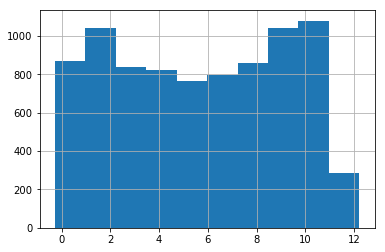

In [19]:
test['ans'].hist()

In [20]:
test['ans'].describe()

count    8409.000000
mean        5.696277
std         3.457993
min        -0.276554
25%         2.523626
50%         5.720650
75%         8.889917
max        12.215004
Name: ans, dtype: float64

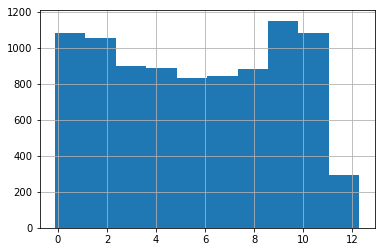

In [21]:
train['y'].hist()

In [22]:
train['y'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: y, dtype: float64